Credits:
* First part is based on YSDA [Practical RL course week04 materials](https://github.com/yandexdataschool/Practical_RL/tree/master/week04_%5Brecap%5D_deep_learning).
* Second part is based on PyTorch official tutorials and [this kaggle kernel](https://www.kaggle.com/pinocookie/pytorch-dataset-and-dataloader)
* Third part is based on PyTorch tutorial by [Stanford CS 231n course](http://cs231n.stanford.edu)

_This notebook__ will remind you how to use pytorch low and high-level core. You can install it [here](http://pytorch.org/).

__Pytorch feels__ differently than other frameworks (like tensorflow/theano) on almost every level. TensorFlow makes your code live in two "worlds" simultaneously:  symbolic graphs and actual tensors. First you declare a symbolic "recipe" of how to get from inputs to outputs, then feed it with actual minibatches of data.  In pytorch, __there's only one world__: all tensors have a numeric value.

You compute outputs on the fly without pre-declaring anything. The code looks exactly as in pure numpy with one exception: pytorch computes gradients for you. And can run stuff on GPU. And has a number of pre-implemented building blocks for your neural nets. [And a few more things.](https://medium.com/towards-data-science/pytorch-vs-tensorflow-spotting-the-difference-25c75777377b)

Let's dive into it!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision
from torchvision import transforms

## Task 1: Tensormancy

__1.1 The [_disclaimer_](https://gist.githubusercontent.com/justheuristic/e2c1fa28ca02670cabc42cacf3902796/raw/fd3d935cef63a01b85ed2790b5c11c370245cbd7/stddisclaimer.h)__

Let's write another function, this time in polar coordinates:
$$\rho(\theta) = (1 + 0.9 \cdot cos (6 \cdot \theta) ) \cdot (1 + 0.01 \cdot cos(24 \cdot \theta)) \cdot (0.5 + 0.05 \cdot cos(200 \cdot \theta)) \cdot (10 + sin(10 \cdot \theta))$$


Then convert it into cartesian coordinates ([howto](http://www.mathsisfun.com/polar-cartesian-coordinates.html)) and plot the results.

Use torch tensors only: no lists, loops, numpy arrays, etc.

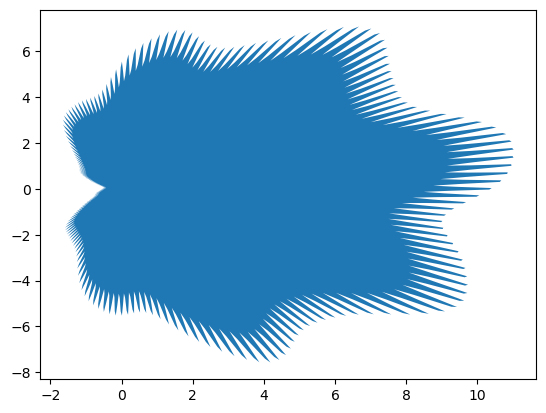

In [2]:
theta = torch.linspace(-np.pi, np.pi, steps = 1000)
rho = (1 + 0.9*torch.cos(theta)) * \
    (1 + 0.01*torch.cos(24*theta)) * \
    (0.5 + 0.05*torch.cos(200*theta)) * \
    (10 + torch.sin(10*theta))

x = rho * torch.cos(theta)
y = rho * torch.sin(theta)

plt.subplots(1, 1)
plt.fill(x.numpy(), y.numpy())

### Task 2: Using the Dataloader

In [3]:
from torch import nn
from torch.nn import functional as F
from notmnist import load_notmnist

In [4]:
X_train, y_train, X_test, y_test = load_notmnist()

Parsing...
found broken img: ./notMNIST_small\A\RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small\F\Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
Done


In [5]:
class DatasetMNIST(Dataset):
    def __init__(self, path='./notMNIST_small', letters='ABCDEFGHIJ', transform=None):
        self.data, self.labels, _, _ = load_notmnist(path=path, letters=letters, test_size=0)
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        # load image as ndarray type (Height * Width * Channels)
        # be carefull for converting dtype to np.uint8 [Unsigned integer (0 to 255)]
        # in this example, i don't use ToTensor() method of torchvision.transforms
        # so you can convert numpy ndarray shape to tensor in PyTorch (H, W, C) --> (C, H, W)
        
        image = self.data[index].transpose(1, 2, 0)
        label = self.labels[index]
        
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [6]:
full_dataset = DatasetMNIST('./notMNIST_small', 'AB', transform=None)

Parsing...
found broken img: ./notMNIST_small\A\RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
Done


In [7]:
img, lab = full_dataset.__getitem__(0)
print(img.shape)
print(type(img))

(28, 28, 1)
<class 'numpy.ndarray'>


In [8]:
a = torchvision.transforms.ToTensor()

a(img).shape

torch.Size([1, 28, 28])

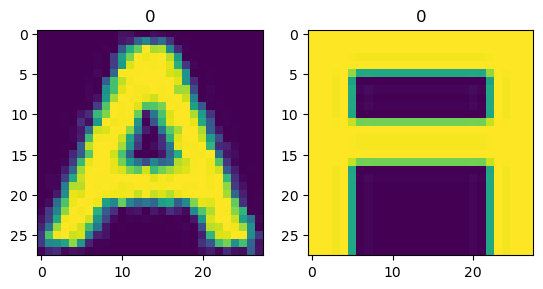

In [9]:
inds = np.random.randint(len(full_dataset), size=2)

for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.imshow(full_dataset[i][0].reshape((28,28)))
    plt.title(str(full_dataset[i][1]))

### Dataloader

In [10]:
train_loader = DataLoader(full_dataset, batch_size=8, shuffle=True)

In [11]:
train_iter = iter(train_loader)
print(type(train_iter))

<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>


In [12]:
images, labels = next(train_iter)

print(f"images shape = {images.size()}")
print(f"labels shape = {labels.size()}")

images shape = torch.Size([8, 28, 28, 1])
labels shape = torch.Size([8])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
C:\Users\Windows\anaconda3\lib\site-packages\matplotlib\text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Text(0.5, 1.0, '[1 1 1 1 1 1 0 1]')

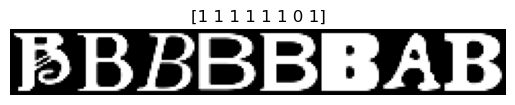

In [13]:
grid = torchvision.utils.make_grid(images.permute([0, 3, 1, 2]))

plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis('off')
plt.title(labels.numpy())

### Now with transforms

In [14]:
train_dataset_with_transform = DatasetMNIST(
    transform=torchvision.transforms.ToTensor()
)

Parsing...
found broken img: ./notMNIST_small\A\RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small\F\Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
Done


In [15]:
img, lab = train_dataset_with_transform.__getitem__(0)

print('image shape at the first row : {}'.format(img.size()))

image shape at the first row : torch.Size([1, 28, 28])


In [16]:
train_loader_tr = DataLoader(train_dataset_with_transform, batch_size=8, shuffle=True)

train_iter_tr = iter(train_loader_tr)
print(type(train_iter_tr))

images, labels = next(train_iter_tr)

print('images shape on batch size = {}'.format(images.size()))
print('labels shape on batch size = {}'.format(labels.size()))

<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>
images shape on batch size = torch.Size([8, 1, 28, 28])
labels shape on batch size = torch.Size([8])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


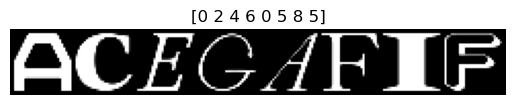

In [17]:
grid = torchvision.utils.make_grid(images)

plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis('off')
plt.title(labels.numpy());

### Combine some transforms
For that we need torch COMPOSE class

In [18]:
class Flatten():
    def __call__(self, pic):
        return pic.flatten()
    
    def __repr__(self):
        return self.__class__.__name__ + '()'

In [19]:
a = Flatten()
a(img).shape

torch.Size([784])

In [20]:
new_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    Flatten()
])

## Putting All together

In [21]:
import time
from IPython.display import clear_output

In [22]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

In [23]:
def subset_ind(dataset, ratio):
    return np.random.choice(len(dataset), size = int(ratio*len(dataset)), replace = False)

In [24]:
dataset = DatasetMNIST(
    './notMNIST_small',
    transform=new_transform
)

shrink_inds = subset_ind(dataset, 0.2)
dataset = Subset(dataset, shrink_inds)
print(f'\n\n dataset size: {len(dataset)}, labels: {np.unique(dataset.dataset.labels)}')

Parsing...
found broken img: ./notMNIST_small\A\RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small\F\Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
Done


 dataset size: 3744, labels: [0 1 2 3 4 5 6 7 8 9]


In [25]:
val_size = 0.2
val_inds = subset_ind(dataset, val_size)
train_dataset = Subset(dataset, [i for i in range(len(dataset)) if i not in val_inds])
val_dataset = Subset(dataset, val_inds)

print(f'  training size: {len(train_dataset)}\nvalidation size: {len(val_dataset)}')

  training size: 2996
validation size: 748


In [26]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [27]:
loss_func = nn.CrossEntropyLoss()

In [28]:
model = nn.Sequential(
    nn.Linear(784, 10),
    #nn.Sigmoid()
)
model.to(device, torch.float32)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [29]:
def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs):
    train_loss = []
    val_loss = []
    val_accuracy = []
    
    for epoch in range(n_epochs):
        epoch_train_loss = []
        epoch_val_loss = []
        epoch_val_accuracy = []
        start_time = time.time()
        
        model.train(True)
        for X_batch, y_batch in train_loader:
            X_batch.to(device)
            y_batch.to(device)
            
            opt.zero_grad()
            
            preds = model(X_batch)
            loss = loss_fn(preds, y_batch.type(torch.LongTensor))
            loss.backward()
            opt.step()
            
            epoch_train_loss.append(loss.item())
            
        model.train(False)
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch.to(device)
                y_batch.to(device)
                preds = model(X_batch)
                loss = loss_fn(preds, y_batch.type(torch.LongTensor))
                epoch_val_loss.append(loss.item())
                y_pred = preds.max(1)[1].data
                epoch_val_accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy()))
                
        print(f" Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time}")
        
        train_loss.append(np.mean(epoch_train_loss))
        val_loss.append(np.mean(epoch_val_loss))
        val_accuracy.append(np.mean(epoch_val_accuracy))
        
        print(f"\t  training loss: {train_loss[-1]:.6f}")
        print(f"\tvalidation loss: {val_loss[-1]:.6f}")
        print(f"\tvalidation accuracy: {val_accuracy[-1]:.3f}")

    return train_loss, val_loss, val_accuracy

def plot_train_process(train_loss, val_loss, val_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title('Loss')
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].legend()

    axes[1].set_title('Validation accuracy')
    axes[1].plot(val_accuracy)

In [30]:
n_epochs = 30
train_loss, val_loss, val_accuracy = train_model(model, train_loader, val_loader, loss_func, opt, n_epochs)

 Epoch 1 of 30 took 0.1872713565826416
	  training loss: 0.805769
	validation loss: 0.550085
	validation accuracy: 0.854
 Epoch 2 of 30 took 0.20314431190490723
	  training loss: 0.484203
	validation loss: 0.520003
	validation accuracy: 0.867
 Epoch 3 of 30 took 0.20756244659423828
	  training loss: 0.423203
	validation loss: 0.528971
	validation accuracy: 0.872
 Epoch 4 of 30 took 0.20516371726989746
	  training loss: 0.386516
	validation loss: 0.504467
	validation accuracy: 0.873
 Epoch 5 of 30 took 0.20418858528137207
	  training loss: 0.362244
	validation loss: 0.490001
	validation accuracy: 0.875
 Epoch 6 of 30 took 0.23937416076660156
	  training loss: 0.343623
	validation loss: 0.518294
	validation accuracy: 0.872
 Epoch 7 of 30 took 0.20544934272766113
	  training loss: 0.322243
	validation loss: 0.516825
	validation accuracy: 0.872
 Epoch 8 of 30 took 0.2089383602142334
	  training loss: 0.303322
	validation loss: 0.521368
	validation accuracy: 0.877
 Epoch 9 of 30 took 0.2070

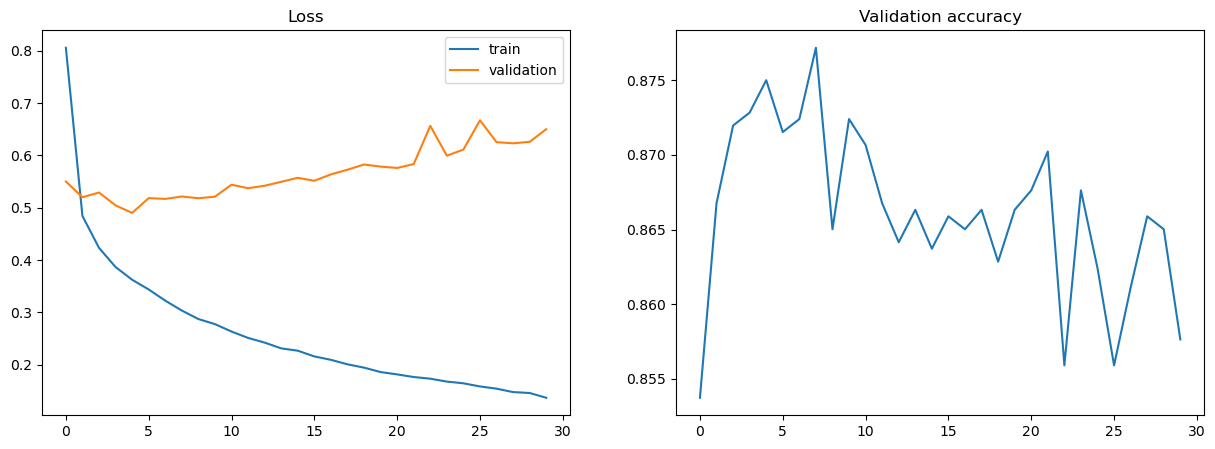

In [31]:
plot_train_process(train_loss, val_loss, val_accuracy)

## REal network

In [32]:
model = nn.Sequential(
    nn.Linear(784, 500),
    nn.ReLU(),
    nn.Linear(500, 200),
    nn.ReLU(),
    nn.Linear(200, 10)
)
model.to(device, torch.float32)
opt = torch.optim.Adam(model.parameters(), lr = 1e-3)

In [33]:
n_epochs = 30
train_loss, val_loss, val_accuracy = train_model(model, train_loader, val_loader, loss_func, opt, n_epochs)

 Epoch 1 of 30 took 0.7091660499572754
	  training loss: 0.658075
	validation loss: 0.474306
	validation accuracy: 0.868
 Epoch 2 of 30 took 0.7420682907104492
	  training loss: 0.336075
	validation loss: 0.455900
	validation accuracy: 0.861
 Epoch 3 of 30 took 0.7382240295410156
	  training loss: 0.238006
	validation loss: 0.471672
	validation accuracy: 0.877
 Epoch 4 of 30 took 0.743685245513916
	  training loss: 0.169042
	validation loss: 0.528933
	validation accuracy: 0.860
 Epoch 5 of 30 took 0.7865679264068604
	  training loss: 0.129084
	validation loss: 0.553763
	validation accuracy: 0.871
 Epoch 6 of 30 took 0.7631702423095703
	  training loss: 0.099243
	validation loss: 0.524253
	validation accuracy: 0.880
 Epoch 7 of 30 took 0.8691878318786621
	  training loss: 0.071300
	validation loss: 0.654259
	validation accuracy: 0.880
 Epoch 8 of 30 took 0.8225500583648682
	  training loss: 0.050127
	validation loss: 0.597881
	validation accuracy: 0.874
 Epoch 9 of 30 took 0.87410449981

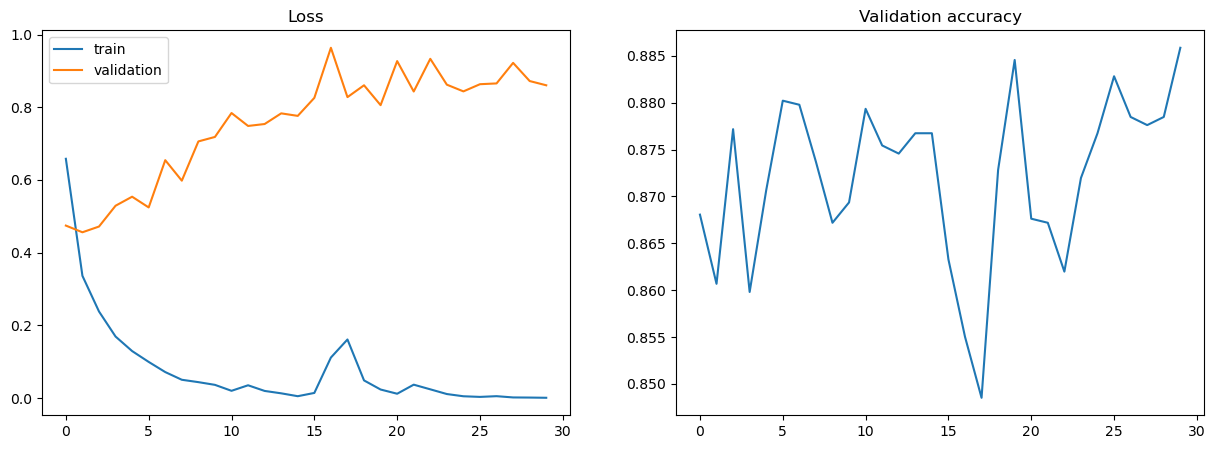

In [34]:
plot_train_process(train_loss, val_loss, val_accuracy)

# Now my turn

### Dropout

In [35]:
from torchsummary import summary

In [37]:
model = nn.Sequential(
    nn.Linear(784, 500),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(500, 200),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(200, 10)
)
model.to(device, torch.float32)
opt = torch.optim.Adam(model.parameters(), lr = 1e-3)

In [38]:
summary(model, (784,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 500]         392,500
              ReLU-2                  [-1, 500]               0
           Dropout-3                  [-1, 500]               0
            Linear-4                  [-1, 200]         100,200
              ReLU-5                  [-1, 200]               0
           Dropout-6                  [-1, 200]               0
            Linear-7                   [-1, 10]           2,010
Total params: 494,710
Trainable params: 494,710
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.89
Estimated Total Size (MB): 1.91
----------------------------------------------------------------


In [39]:
n_epochs = 30
train_loss, val_loss, val_accuracy = train_model(model, train_loader, val_loader, loss_func, opt, n_epochs)

 Epoch 1 of 30 took 0.5706562995910645
	  training loss: 0.716023
	validation loss: 0.481331
	validation accuracy: 0.845
 Epoch 2 of 30 took 0.5812132358551025
	  training loss: 0.371491
	validation loss: 0.440208
	validation accuracy: 0.883
 Epoch 3 of 30 took 0.6178359985351562
	  training loss: 0.299584
	validation loss: 0.474272
	validation accuracy: 0.867
 Epoch 4 of 30 took 0.5944108963012695
	  training loss: 0.240830
	validation loss: 0.450669
	validation accuracy: 0.872
 Epoch 5 of 30 took 0.5935487747192383
	  training loss: 0.176750
	validation loss: 0.478239
	validation accuracy: 0.882
 Epoch 6 of 30 took 0.5764155387878418
	  training loss: 0.153188
	validation loss: 0.522982
	validation accuracy: 0.865
 Epoch 7 of 30 took 0.6062119007110596
	  training loss: 0.122030
	validation loss: 0.544522
	validation accuracy: 0.879
 Epoch 8 of 30 took 0.5800731182098389
	  training loss: 0.115764
	validation loss: 0.559498
	validation accuracy: 0.882
 Epoch 9 of 30 took 0.6430253982

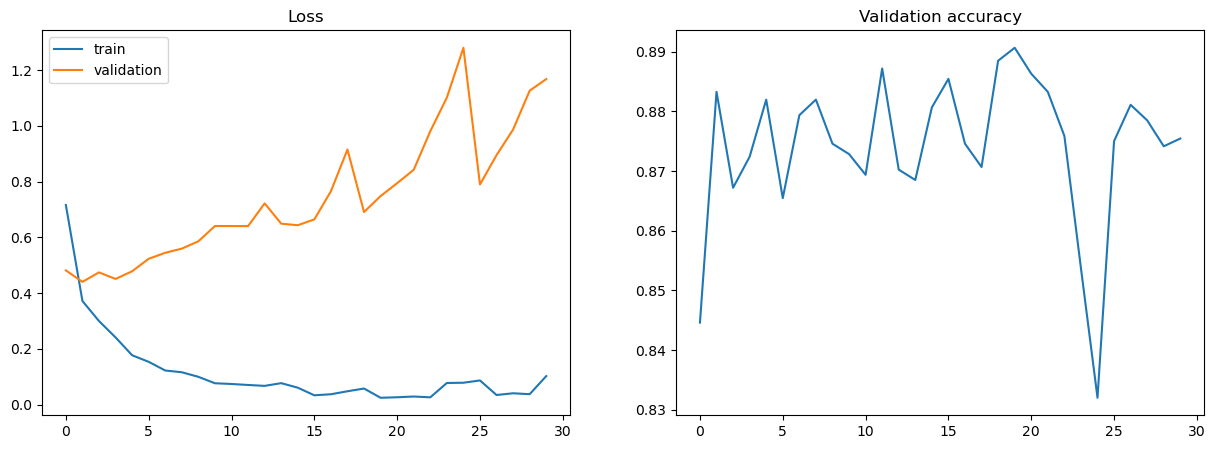

In [40]:
plot_train_process(train_loss, val_loss, val_accuracy)

In [41]:
model = nn.Sequential(
    nn.BatchNorm1d(784),
    nn.Linear(784, 500),
    nn.ReLU(),
    nn.BatchNorm1d(500),
    nn.Linear(500, 200),
    nn.ReLU(),
    nn.BatchNorm1d(200),
    nn.Linear(200, 10)
)
model.to(device, torch.float32)
opt = torch.optim.Adam(model.parameters(), lr = 1e-3)

In [42]:
n_epochs = 30
train_loss, val_loss, val_accuracy = train_model(model, train_loader, val_loader, loss_func, opt, n_epochs)

 Epoch 1 of 30 took 0.6977834701538086
	  training loss: 0.622307
	validation loss: 0.489216
	validation accuracy: 0.862
 Epoch 2 of 30 took 0.742119550704956
	  training loss: 0.366498
	validation loss: 0.409487
	validation accuracy: 0.873
 Epoch 3 of 30 took 0.7022006511688232
	  training loss: 0.283175
	validation loss: 0.450730
	validation accuracy: 0.872
 Epoch 4 of 30 took 0.6949067115783691
	  training loss: 0.223222
	validation loss: 0.472450
	validation accuracy: 0.865
 Epoch 5 of 30 took 0.6967017650604248
	  training loss: 0.184267
	validation loss: 0.466519
	validation accuracy: 0.878
 Epoch 6 of 30 took 0.6697897911071777
	  training loss: 0.139217
	validation loss: 0.497932
	validation accuracy: 0.867
 Epoch 7 of 30 took 0.7528862953186035
	  training loss: 0.133821
	validation loss: 0.563889
	validation accuracy: 0.856
 Epoch 8 of 30 took 0.7173089981079102
	  training loss: 0.130161
	validation loss: 0.464969
	validation accuracy: 0.880
 Epoch 9 of 30 took 0.67363834381

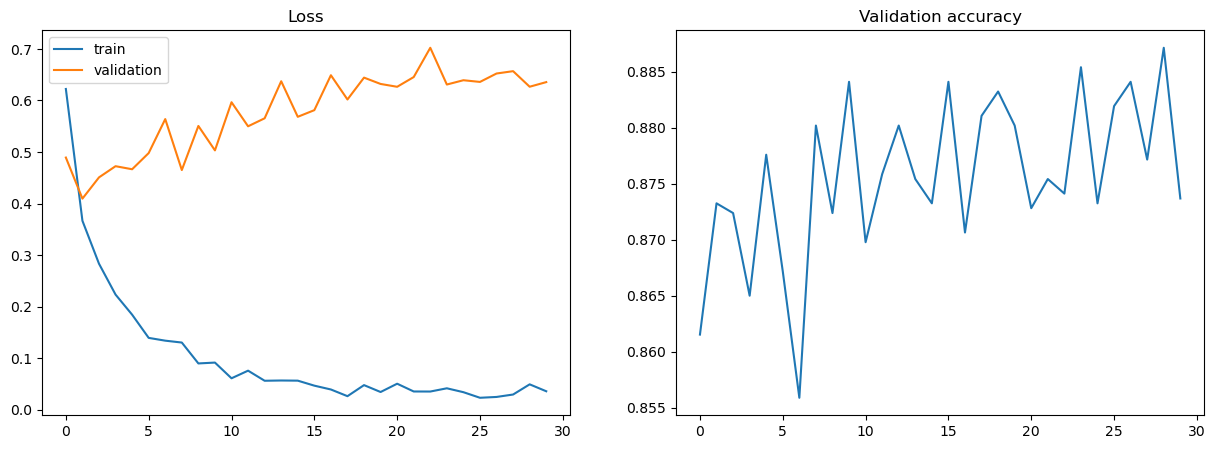

In [43]:
plot_train_process(train_loss, val_loss, val_accuracy)

In [48]:
model = nn.Sequential(
    nn.BatchNorm1d(784),
    nn.Linear(784, 500),
    nn.ReLU(),
    nn.Dropout(p=0.6),
    nn.BatchNorm1d(500),
    nn.Linear(500, 200),
    nn.ReLU(),
    nn.Dropout(p=0.4),
    nn.BatchNorm1d(200),
    nn.Linear(200, 10)
)
model.to(device, torch.float32)
opt = torch.optim.Adam(model.parameters(), lr = 1e-3)

In [49]:
n_epochs = 30
train_loss, val_loss, val_accuracy = train_model(model, train_loader, val_loader, loss_func, opt, n_epochs)

 Epoch 1 of 30 took 0.7129487991333008
	  training loss: 1.019946
	validation loss: 0.506918
	validation accuracy: 0.866
 Epoch 2 of 30 took 0.6781041622161865
	  training loss: 0.593190
	validation loss: 0.438407
	validation accuracy: 0.872
 Epoch 3 of 30 took 0.80751633644104
	  training loss: 0.529176
	validation loss: 0.428966
	validation accuracy: 0.878
 Epoch 4 of 30 took 0.7000186443328857
	  training loss: 0.500993
	validation loss: 0.403881
	validation accuracy: 0.879
 Epoch 5 of 30 took 0.6997179985046387
	  training loss: 0.455469
	validation loss: 0.394151
	validation accuracy: 0.880
 Epoch 6 of 30 took 0.7722597122192383
	  training loss: 0.408965
	validation loss: 0.374963
	validation accuracy: 0.892
 Epoch 7 of 30 took 0.9070239067077637
	  training loss: 0.416044
	validation loss: 0.385338
	validation accuracy: 0.876
 Epoch 8 of 30 took 0.9537692070007324
	  training loss: 0.398445
	validation loss: 0.396306
	validation accuracy: 0.881
 Epoch 9 of 30 took 0.996317386627

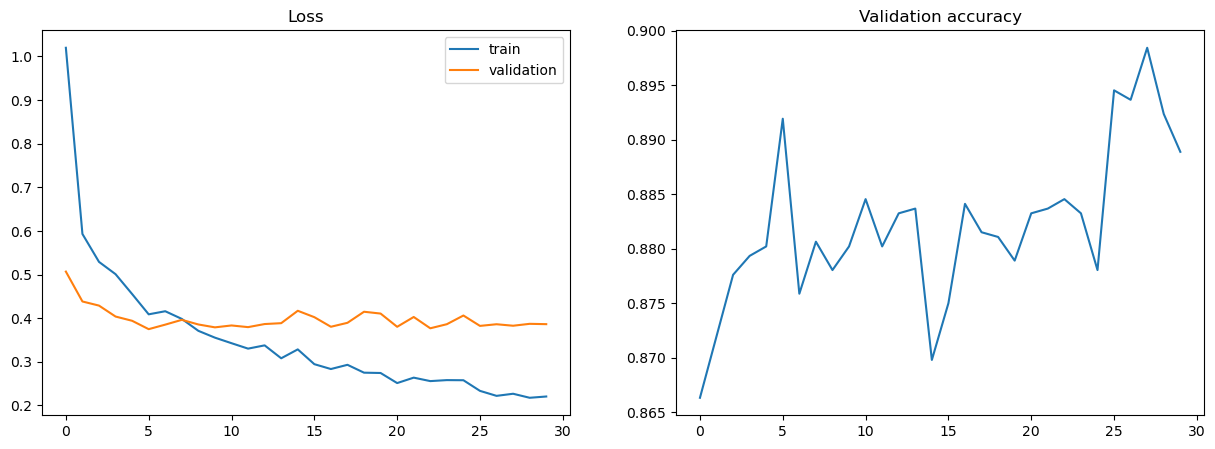

In [50]:
plot_train_process(train_loss, val_loss, val_accuracy)

### More about pytorch:
* Using torch on GPU and multi-GPU - [link](http://pytorch.org/docs/master/notes/cuda.html)
* More tutorials on pytorch - [link](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)
* Pytorch examples - a repo that implements many cool DL models in pytorch - [link](https://github.com/pytorch/examples)
* Practical pytorch - a repo that implements some... other cool DL models... yes, in pytorch - [link](https://github.com/spro/practical-pytorch)
* And some more - [link](https://www.reddit.com/r/pytorch/comments/6z0yeo/pytorch_and_pytorch_tricks_for_kaggle/)